# Regresión Ponderada Geografica GWR

In [16]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tabulate import tabulate
np.float = float

In [3]:
gdf = gpd.read_file("https://github.com/algarciach/AnalisisGeoespacial/raw/main/Covid19_model/Data/covid19_municipios_antioquia.gpkg")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   codigo_municipio     125 non-null    object  
 1   nombre_municipio     125 non-null    object  
 2   codigo_subregion     125 non-null    object  
 3   nombre_subregion     125 non-null    object  
 4   area_municipio       125 non-null    float64 
 5   altitud              125 non-null    float64 
 6   temperatura          125 non-null    float64 
 7   humedad_relativa     125 non-null    float64 
 8   poblacion            125 non-null    int64   
 9   densidad             125 non-null    float64 
 10  muertes_covid19      125 non-null    int64   
 11  recuperados_covid19  125 non-null    int64   
 12  cfr                  125 non-null    float64 
 13  geometry             125 non-null    geometry
dtypes: float64(6), geometry(1), int64(3), object(4)
memory usage: 13.8

In [4]:
gdf['y_log'] = np.log(gdf['cfr'] + 1)
g_y = gdf['y_log'].values.reshape(-1, 1)

In [5]:
# Define coordinates as points
u = gdf.centroid.x
v = gdf.centroid.y
g_coords = list(zip(u, v))



/var/folders/nq/kj34bm5140bgwbktdx1z94cm0000gn/T/ipykernel_25431/1898457282.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  u = gdf.centroid.x
/var/folders/nq/kj34bm5140bgwbktdx1z94cm0000gn/T/ipykernel_25431/1898457282.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  v = gdf.centroid.y


In [7]:
variables = ['densidad', 'altitud', 'temperatura', 'humedad_relativa']
scaler = StandardScaler()
g_X_num = scaler.fit_transform(gdf[variables])

In [8]:
model = GWR(g_coords, g_y, g_X_num, 10000, fixed=True, kernel='gaussian').fit()
# Print model summary
print(model.summary())

Model type                                                         Gaussian
Number of observations:                                                 125
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             12.548
Log-likelihood:                                                     -33.696
AIC:                                                                 77.391
AICc:                                                                80.103
BIC:                                                               -566.850
R2:                                                                   0.197
Adj. R2:                                                              0.170

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [9]:
model = GWR(g_coords, g_y, g_X_num, 5, fixed=False, kernel='gaussian').fit()
# Print model summary
print(model.summary())

Model type                                                         Gaussian
Number of observations:                                                 125
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             12.548
Log-likelihood:                                                     -33.696
AIC:                                                                 77.391
AICc:                                                                80.103
BIC:                                                               -566.850
R2:                                                                   0.197
Adj. R2:                                                              0.170

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [11]:
gwr_selector = Sel_BW(g_coords, g_y, g_X_num, multi=True, kernel='bisquare', fixed=True)
selector = gwr_selector.search()
# Print selector summary
print(selector)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[6.8  6.8  6.8  4.49 6.8 ]


In [13]:
model = MGWR(g_coords, g_y, g_X_num, gwr_selector, kernel='bisquare', fixed=True).fit()
model.summary()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 125
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             12.548
Log-likelihood:                                                     -33.696
AIC:                                                                 77.391
AICc:                                                                80.103
BIC:                                                               -566.850
R2:                                                                   0.197
Adj. R2:                                                              0.170

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


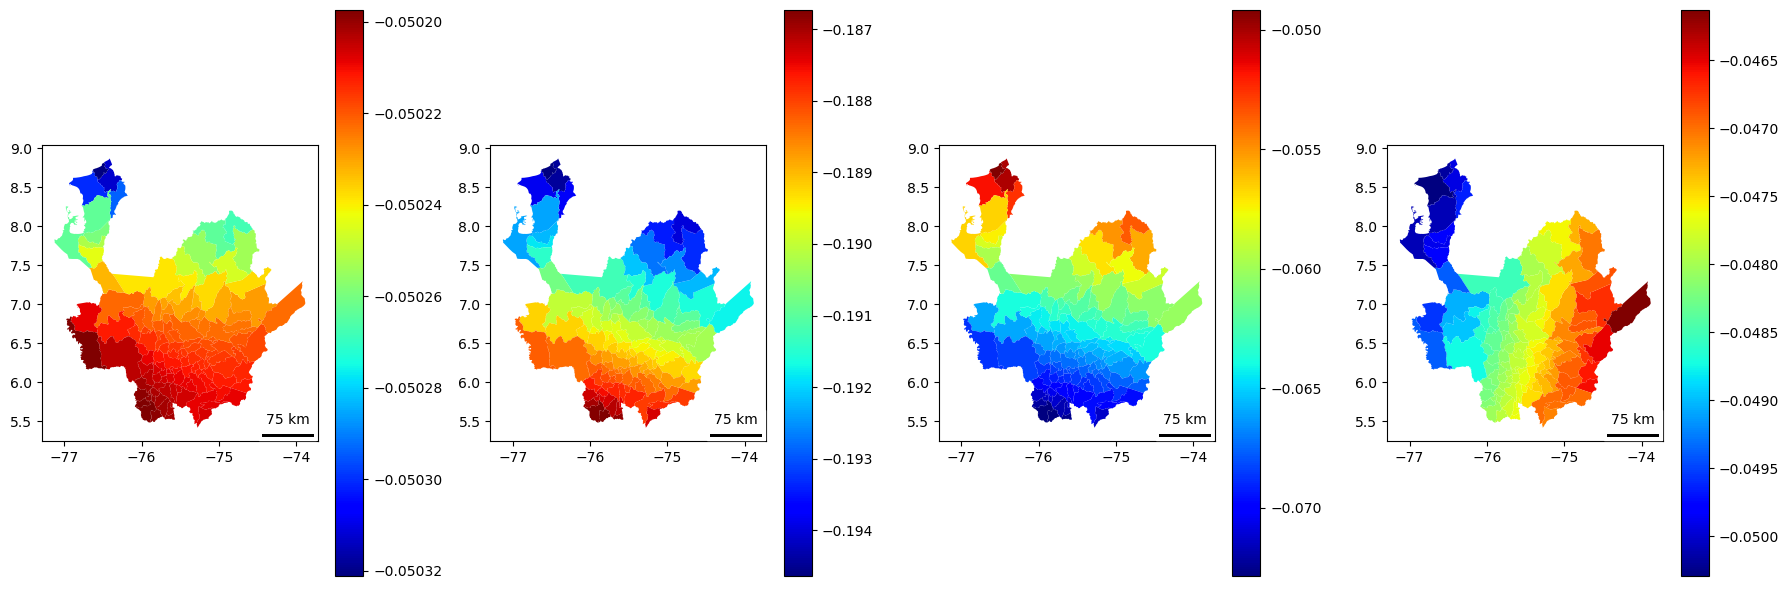

In [18]:
local_params = model.params

param_names = ['densidad', 'altitud', 'temperatura', 'humedad_relativa']
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

data_clean = gdf.to_crs(epsg=4326)

for i, param_name in enumerate(param_names):
    ax = axes[i]
    data_clean[f'coef_{param_name}'] = local_params[:, i+1]
    data_clean.plot(column=f'coef_{param_name}', ax=ax, cmap=plt.cm.jet, legend=True)
    scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
    ax.add_artist(scalebar)

plt.tight_layout()
plt.show()

/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.11/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


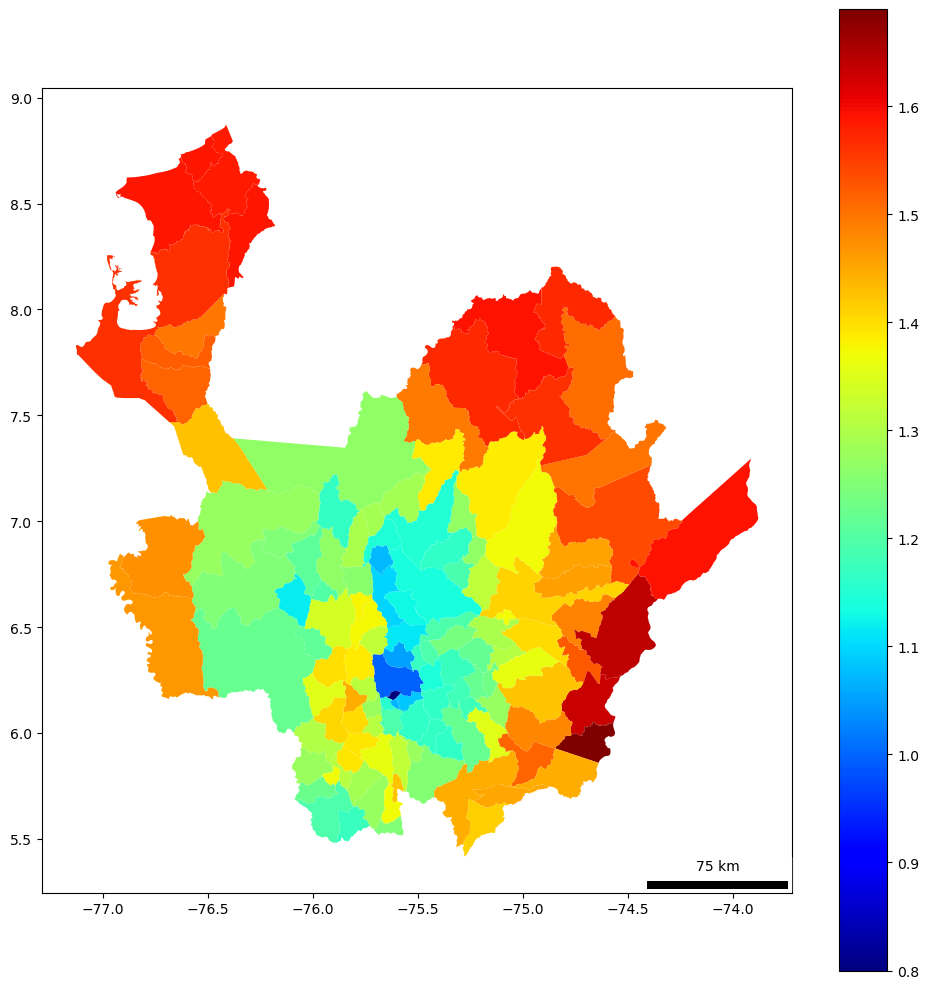

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
data_clean['fitted'] = model.predy
data_clean.plot(column='fitted', ax=ax, cmap=plt.cm.jet, legend=True)
scalebar = ScaleBar(111319.49079327357, "m", location='lower right', scale_loc='top', length_fraction=0.25, font_properties={"size": 10})
ax.add_artist(scalebar)
plt.tight_layout()
plt.show()